# CHIC602 Worksheet

student_ID = "36112985"

<br>

**Libraries**

In [1]:
import sqlite3
import pandas as pd
import numpy as np

import logging

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns


<br>

**Settings**

* az.style.use('arviz-darkgrid')
* sns.set_style('darkgrid')

In [2]:
sns.set(font_scale=1)
az.style.use('arviz-darkgrid')

<br>

**Logging**

In [3]:
# Logging
logging.basicConfig(level=logging.INFO,
                    format='\n%(message)s\n%(asctime)s.%(msecs)03d\n',
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

## Reading the Data


### Database connection instance

A simple class for creating database connection instances.

In [4]:
class SQLITE:

    def __init__(self, databaseuri: str):
        """
        
        :param databaseuri: The URI (uniform resource identifier) of a database file
        """
        
        self.databaseuri = databaseuri

    def connecting(self):
        """
        
        :return: database connection instance
        """

        connection = None

        try:
            connection = sqlite3.connect(self.databaseuri)
        except ConnectionError as err:
            raise Exception(err.strerror) in err

        return connection

<br>

A database connection instance for `gpinhours.sqlite`

In [5]:
sqlite = SQLITE(databaseuri='../data/gpinhours.sqlite')

<br>
<br>

### Data reading

Reading the `inhours` table of `gpinhours.sqlite`

In [6]:
connection = sqlite.connecting()
query = 'SELECT * FROM inhours'
inhours = pd.read_sql_query(query, connection)
connection.close()

In [7]:
inhours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47084 entries, 0 to 47083
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CODE        47084 non-null  object 
 1   NAME        47084 non-null  object 
 2   TOTAL_POP   46862 non-null  object 
 3   Flu_OBS     46669 non-null  float64
 4   Vom_OBS     46672 non-null  float64
 5   Diarr_OBS   46672 non-null  float64
 6   Gastro_OBS  46757 non-null  float64
 7   lastdate    47084 non-null  float64
 8   week        47084 non-null  float64
dtypes: float64(6), object(3)
memory usage: 3.2+ MB


<br>
<br>

## Data Cleaning

In [8]:
inhours.head()

,CODE,NAME,TOTAL_POP,Flu_OBS,Vom_OBS,Diarr_OBS,Gastro_OBS,lastdate,week
0,E09000002,Barking and Dagenham,63009,1.0,13.0,9.0,33.0,17741.0,30.0
1,E09000003,Barnet,225813,1.0,40.0,101.0,148.0,17741.0,30.0
2,E09000004,Bexley,46339,1.0,11.0,12.0,24.0,17741.0,30.0
3,E09000005,Brent,178399,1.0,43.0,57.0,97.0,17741.0,30.0
4,E09000006,Bromley,168381,0.0,19.0,43.0,79.0,17741.0,30.0


<br>
<br>

### Fix the population count

<br>

**The new field `POP`**

* Creating the function `as_number_or_nan`, which converts the contents of `inhours.TOTAL_POP` to numeric values, and sets its invalid values to `NaN`.
* Assign the converted values of `inhours.TOTAL_POP`  to  a new field $\rightarrow$ `inhours.POP`.

In [9]:
def as_number_or_nan(x: pd.Series):
    """
    
    :param x: a series to be converted
    :return: a series with numeris or NaN values only
    """
    
    return pd.to_numeric(x, errors='coerce')
    

In [10]:
inhours.loc[:, 'POP'] = as_number_or_nan(x = inhours.TOTAL_POP)

In [11]:
inhours.head()

,CODE,NAME,TOTAL_POP,Flu_OBS,Vom_OBS,Diarr_OBS,Gastro_OBS,lastdate,week,POP
0,E09000002,Barking and Dagenham,63009,1.0,13.0,9.0,33.0,17741.0,30.0,63009.0
1,E09000003,Barnet,225813,1.0,40.0,101.0,148.0,17741.0,30.0,225813.0
2,E09000004,Bexley,46339,1.0,11.0,12.0,24.0,17741.0,30.0,46339.0
3,E09000005,Brent,178399,1.0,43.0,57.0,97.0,17741.0,30.0,178399.0
4,E09000006,Bromley,168381,0.0,19.0,43.0,79.0,17741.0,30.0,168381.0


<br>

**Missing values**

The local authorities that had population values that could not be converted, and the number of unconvertible records per local authority.

In [12]:
inhours.loc[np.isnan(inhours.POP), 'NAME'].value_counts()

Bury                         115
Isle of Wight                 53
Wokingham                     50
Barking and Dagenham           1
Rochdale                       1
Merton                         1
Cheshire West and Chester      1
Knowsley                       1
Bexley                         1
Greenwich                      1
Sutton                         1
Lambeth                        1
Herefordshire, County of       1
Name: NAME, dtype: int64

<br>
<br>

### Fix the date

Extracting the dates from the `inhours.lastdate` field; the `inhours.lastdate` field encodes the number of days since the 1 January 1970.

In [13]:
inhours.loc[:, 'date'] = pd.to_datetime(inhours.lastdate, unit='D', origin='unix')

In [14]:
inhours.date.describe(datetime_is_numeric=True)

count                            47084
mean     2017-01-17 20:39:29.620252928
min                2014-01-05 00:00:00
25%                2015-07-17 06:00:00
50%                2017-01-18 12:00:00
75%                2018-07-23 18:00:00
max                2020-01-26 00:00:00
Name: date, dtype: object

<br>
<br>

### Trim the years

<br>

**Records per Year**

The year of each `inhours.date` value

In [15]:
inhours.loc[:, 'year'] = inhours.date.dt.year

<br>

Records per year

In [16]:
inhours.year.value_counts()

2017    7897
2015    7748
2019    7748
2018    7748
2016    7748
2014    7599
2020     596
Name: year, dtype: int64

<br>

Number of records

In [17]:
inhours.shape[0]

47084

<br>

**Excluding 2020**

Excluding 2020

In [18]:
inhours = inhours.loc[inhours.year != 2020, :]

<br>

Hence, the latest counts

In [19]:
inhours.year.value_counts()

2017    7897
2015    7748
2019    7748
2018    7748
2016    7748
2014    7599
Name: year, dtype: int64

<br>

Number of records

In [20]:
inhours.shape

(46488, 12)

<br>
<br>

### Drop zero populations

In [21]:
inhours = inhours.loc[inhours.POP != 0, :]

In [22]:
inhours = inhours.loc[~np.isnan(inhours.POP), :]

<br>
<br>

### Final clean data

In [23]:
inhours

,CODE,NAME,TOTAL_POP,Flu_OBS,Vom_OBS,Diarr_OBS,Gastro_OBS,lastdate,week,POP,date,year
0,E09000002,Barking and Dagenham,63009,1.0,13.0,9.0,33.0,17741.0,30.0,63009.0,2018-07-29,2018
1,E09000003,Barnet,225813,1.0,40.0,101.0,148.0,17741.0,30.0,225813.0,2018-07-29,2018
2,E09000004,Bexley,46339,1.0,11.0,12.0,24.0,17741.0,30.0,46339.0,2018-07-29,2018
3,E09000005,Brent,178399,1.0,43.0,57.0,97.0,17741.0,30.0,178399.0,2018-07-29,2018
4,E09000006,Bromley,168381,0.0,19.0,43.0,79.0,17741.0,30.0,168381.0,2018-07-29,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
46483,E06000041,Wokingham,150642,14.0,12.0,22.0,38.0,18258.0,52.0,150642.0,2019-12-28,2019
46484,E10000014,Hampshire,1284063,117.0,120.0,240.0,376.0,18258.0,52.0,1284063.0,2019-12-28,2019
46485,E06000046,Isle of Wight,67289,1.0,1.0,1.0,44.0,18258.0,52.0,67289.0,2019-12-28,2019
46486,E06000044,Portsmouth,183875,1.0,1.0,1.0,48.0,18258.0,52.0,183875.0,2019-12-28,2019


<br>
<br>

## North South Divide


### Read the table

<br>

Reading the `localauth` table of `gpinhours.sqlite`

In [24]:
connection = sqlite.connecting()
query = 'SELECT * FROM localauth'
localauth = pd.read_sql_query(query, connection)
connection.close()

In [25]:
localauth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NAME    149 non-null    object
 1   NS      149 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [26]:
localauth

,NAME,NS
0,Barking and Dagenham,South
1,Barnet,South
2,Barnsley,North
3,Bath and North East Somerset,South
4,Bedford,South
...,...,...
144,Wirral,North
145,Wokingham,South
146,Wolverhampton,North
147,Worcestershire,North


<br>

### Merge with GP data

<br>

Merging GP data `inhours` & `localauth`

In [27]:
inhoursNS = inhours.merge(localauth, how='left', on='NAME')

In [28]:
inhoursNS

,CODE,NAME,TOTAL_POP,Flu_OBS,Vom_OBS,Diarr_OBS,Gastro_OBS,lastdate,week,POP,date,year,NS
0,E09000002,Barking and Dagenham,63009,1.0,13.0,9.0,33.0,17741.0,30.0,63009.0,2018-07-29,2018,South
1,E09000003,Barnet,225813,1.0,40.0,101.0,148.0,17741.0,30.0,225813.0,2018-07-29,2018,South
2,E09000004,Bexley,46339,1.0,11.0,12.0,24.0,17741.0,30.0,46339.0,2018-07-29,2018,South
3,E09000005,Brent,178399,1.0,43.0,57.0,97.0,17741.0,30.0,178399.0,2018-07-29,2018,South
4,E09000006,Bromley,168381,0.0,19.0,43.0,79.0,17741.0,30.0,168381.0,2018-07-29,2018,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45919,E06000041,Wokingham,150642,14.0,12.0,22.0,38.0,18258.0,52.0,150642.0,2019-12-28,2019,South
45920,E10000014,Hampshire,1284063,117.0,120.0,240.0,376.0,18258.0,52.0,1284063.0,2019-12-28,2019,South
45921,E06000046,Isle of Wight,67289,1.0,1.0,1.0,44.0,18258.0,52.0,67289.0,2019-12-28,2019,South
45922,E06000044,Portsmouth,183875,1.0,1.0,1.0,48.0,18258.0,52.0,183875.0,2019-12-28,2019,South


<br>
<br>

### Group and aggregate

Per year, and per north/south demarcation, the **(a)** total population, and **(b)** total number of consultations per consultation category.

In [29]:
fields = ['NS', 'year', 'POP', 'Flu_OBS', 'Vom_OBS', 'Diarr_OBS', 'Gastro_OBS']

In [30]:
# Either
# inhoursNS[fields].groupby(by=['NS', 'year']).agg('sum')

# Or
aggNS = inhoursNS[fields].groupby(by=['NS', 'year']).agg(Total=('POP', sum), 
                                                         Flu_OBS=('Flu_OBS', sum), 
                                                         Vom_OBS=('Vom_OBS', sum), 
                                                         Diarr_OBS=('Diarr_OBS', sum), 
                                                         Gastro_OBS=('Gastro_OBS', sum))
aggNS

Total  Flu_OBS   Vom_OBS  Diarr_OBS  Gastro_OBS
NS    year                                                       
North 2014  719655399.0  31870.0  144469.0   279606.0    524322.0
      2015  812875983.0  44352.0  155056.0   302202.0    555413.0
      2016  852949550.0  48895.0  159742.0   307934.0    569276.0
      2017  737539944.0  30220.0  122787.0   248197.0    462994.0
      2018  607900399.0  46228.0   90951.0   194246.0    365863.0
      2019  614454668.0  31826.0   87114.0   186457.0    357594.0
South 2014  759999787.0  47093.0  141909.0   283547.0    507028.0
      2015  838254817.0  61180.0  147032.0   300360.0    537786.0
      2016  908035557.0  66822.0  156401.0   308993.0    558159.0
      2017  769928672.0  40572.0  117494.0   245726.0    442456.0
      2018  641245125.0  45791.0   84614.0   191328.0    343863.0
      2019  647648492.0  34353.0   79300.0   180489.0    324279.0

<br>
<br>

### Consultation rates

The consultations per 100,000 people

In [31]:
classes = ['Flu_OBS', 'Vom_OBS', 'Diarr_OBS', 'Gastro_OBS']
rates =  100000 * np.true_divide(aggNS[classes], aggNS[['Total']])
aggNS.loc[:, ['Flu_rate', 'Vom_rate', 'Diarr_rate', 'Gastro_rate']] = rates.to_numpy()

In [32]:
aggNS[['Flu_rate', 'Vom_rate', 'Diarr_rate', 'Gastro_rate']]

Flu_rate   Vom_rate  Diarr_rate  Gastro_rate
NS    year                                              
North 2014  4.428508  20.074747   38.852762    72.857370
      2015  5.456183  19.074988   37.176889    68.326905
      2016  5.732461  18.728189   36.102252    66.742048
      2017  4.097405  16.648183   33.652008    62.775447
      2018  7.604535  14.961497   31.953590    60.184695
      2019  5.179552  14.177449   30.345119    58.196970
South 2014  6.196449  18.672242   37.308826    66.714229
      2015  7.298497  17.540251   35.831587    64.155432
      2016  7.358963  17.224105   34.028734    61.468848
      2017  5.269579  15.260375   31.915424    57.467142
      2018  7.140951  13.195266   29.836952    53.624267
      2019  5.304266  12.244296   27.868358    50.070216

<br>
<br>

### Plot the Rates

In [33]:
aggNSTable = aggNS.reset_index()
aggNSTable.head()

,NS,year,Total,Flu_OBS,Vom_OBS,Diarr_OBS,Gastro_OBS,Flu_rate,Vom_rate,Diarr_rate,Gastro_rate
0,North,2014,719655399.0,31870.0,144469.0,279606.0,524322.0,4.428508,20.074747,38.852762,72.857370
1,North,2015,812875983.0,44352.0,155056.0,302202.0,555413.0,5.456183,19.074988,37.176889,68.326905
2,North,2016,852949550.0,48895.0,159742.0,307934.0,569276.0,5.732461,18.728189,36.102252,66.742048
3,North,2017,737539944.0,30220.0,122787.0,248197.0,462994.0,4.097405,16.648183,33.652008,62.775447
4,North,2018,607900399.0,46228.0,90951.0,194246.0,365863.0,7.604535,14.961497,31.953590,60.184695


<br>

**The graphs**

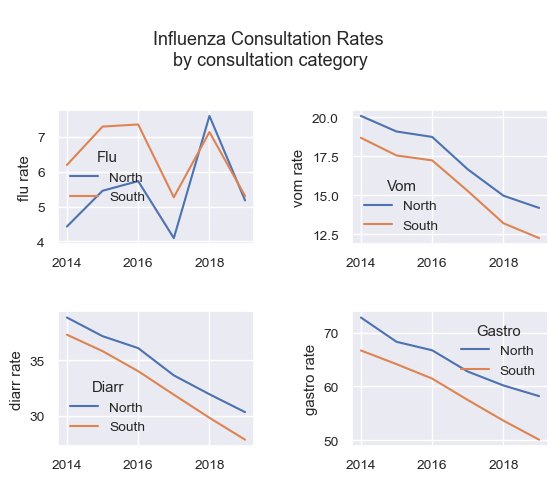

In [34]:
sns.set(font_scale=0.9)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.6))

fig.suptitle("\nInfluenza Consultation Rates\n by consultation category\n", fontdict={'fontsize': 'small'})

plt.subplots_adjust(left=0.20, bottom=0.2, right=0.9, top=0.8, hspace=0.5, wspace=0.5)

g = sns.lineplot(x='year', y='Flu_rate', hue='NS', data=aggNSTable, ax=axes[0, 0])
g.legend(title='Flu', loc='center left')
g.set_xlabel('')
g.set_ylabel('flu rate')

g = sns.lineplot(x='year', y='Vom_rate', hue='NS', data=aggNSTable, ax=axes[0, 1])
g.legend(title='Vom')
g.set_xlabel('')
g.set_ylabel('vom rate')

g = sns.lineplot(x='year', y='Diarr_rate', hue='NS', data=aggNSTable, ax=axes[1, 0]);
g.legend(title='Diarr')
g.set_xlabel('')
g.set_ylabel('diarr rate')


g = sns.lineplot(x='year', y='Gastro_rate', hue='NS', data=aggNSTable, ax=axes[1, 1]);
g.legend(title='Gastro')
g.set_xlabel('');
g.set_ylabel('gastro rate');



<br>
<br>

## Influenza Data


### Grouping and aggregating

Per `inhours.date`, the **(a)** total population, and **(b)** total number of influenza consultations

In [35]:
flu = inhours.groupby(by='date').agg(Total=('POP', sum), Flu_OBS=('Flu_OBS', sum))

<br>

### Compute rates

The influenza consultations per 100,000

In [36]:
flu.loc[:, 'Flu_rate'] = 100000 * np.true_divide(flu.Flu_OBS, flu.Total)

<br>

Each date's year

In [37]:
flu.loc[:, 'year'] = flu.index.year.values

<br>

Finally

In [38]:
flu

,Total,Flu_OBS,Flu_rate,year
date,,,,
2014-01-05,28607373.0,2264.0,7.914044,2014
2014-01-12,29197811.0,2789.0,9.552086,2014
2014-01-19,29350395.0,2236.0,7.618296,2014
2014-01-26,28766178.0,1990.0,6.917846,2014
2014-02-02,29268260.0,2419.0,8.264926,2014
...,...,...,...,...
2019-12-01,22565354.0,1866.0,8.269314,2019
2019-12-08,23279755.0,2378.0,10.214884,2019
2019-12-15,26375563.0,3687.0,13.978849,2019


<br>
<br>

### Plot National Weekly Rates

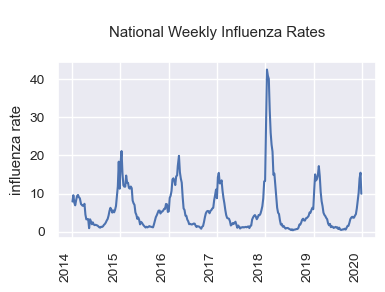

In [39]:
flu.plot(y='Flu_rate', kind='line', figsize=(4.1, 2.6), 
         xlabel='', ylabel='influenza rate', title='\nNational Weekly Influenza Rates\n')
plt.xticks(rotation=90);
plt.legend(labels=['influenza consultations per 100,000']).set_visible(False);

<br>
<br>

## Season Start Detection


### Finding the minimum

<br>

The `when_min` function, which returns the index of the minimum value of a series - the last occurrence of the minimum value.

In [40]:
def when_min(x: pd.Series):
    """
    
    :param x: a time series whose index is a date index
    :return: the last occurrence of the minimum value of a series
    """
    
    return x.where(x==x.min()).last_valid_index()

<br>

Re-ascertaining that the index is sorted in ascending order.

In [41]:
flu.sort_index(inplace = True)

<br>

Hence, the date of each year's minimum value

In [42]:
minimum_value_dates = flu.groupby(by='year').agg(Minimum_value_date=('Flu_rate', when_min))
minimum_value_dates

,Minimum_value_date
year,
2014,2014-05-11
2015,2015-07-12
2016,2016-09-04
2017,2017-06-25
2018,2018-07-29
2019,2019-07-28


<br>
<br>

### Simple Season Start Detection

The `season_start` function detects the start of the influenza season.  In brief 

> Let
>
> * $\alpha$: a year's minimum influenza rate value [last occurrence]
> * $\alpha_{date}$: the date that $\alpha$ occurred
>
> Then `season_start` returns the first date after $\alpha_{date}$ when
>
> &nbsp; &nbsp; &nbsp; $\text{influenza rate} > 2 \alpha$


In [43]:
def season_start(x: pd.Series):
    """
    
    :param x: a time series whose index is a date index
    :return: the first time a value beyond the minimum point exceeds (2 * minimum point value)
    """
    
    # the index of the minimum point of x - last occurence
    minimum_point_index = when_min(x = x)
    
    # the minimum point value
    minimum_point_value = x[minimum_point_index]
    
    # the values of x beyond the minim point
    beyond_minimum_point = x.iloc[ x.index > minimum_point_index ]
    
    # the indices beyond the minimum point that have values > (2 * minimum point value)
    indices = beyond_minimum_point.index[beyond_minimum_point > 2 * minimum_point_value]
    
    # the first time a value beyond the minimum point exceeds (2 * minimum point value)
    return indices.min()    
    
    

In [44]:
season_start_dates = flu.groupby(by='year').agg(Season_start=('Flu_rate', season_start))
season_start_dates

,Season_start
year,
2014,2014-05-18
2015,2015-09-20
2016,2016-09-25
2017,2017-09-24
2018,2018-09-09
2019,2019-09-08


<br>
<br>

### Plot Data with Minima & Season Starts

<br>

**The minima**:  The `y` values are set to $1.5$ so that the minimum point markers point down onto the time series.

In [45]:
minima = minimum_value_dates.copy()
minima.loc[:, 'y'] = 1.5 * np.ones(minimum_value_dates.shape)
logger.info(minima)


     Minimum_value_date    y
year                        
2014         2014-05-11  1.5
2015         2015-07-12  1.5
2016         2016-09-04  1.5
2017         2017-06-25  1.5
2018         2018-07-29  1.5
2019         2019-07-28  1.5
2021-12-20 15:24:29.090



<br>

**The starts**

In [46]:
starts = season_start_dates.copy()
starts.loc[:, 'y'] = np.zeros(season_start_dates.shape)
logger.info(starts)


     Season_start    y
year                  
2014   2014-05-18  0.0
2015   2015-09-20  0.0
2016   2016-09-25  0.0
2017   2017-09-24  0.0
2018   2018-09-09  0.0
2019   2019-09-08  0.0
2021-12-20 15:24:29.102



<br>

**The graph**

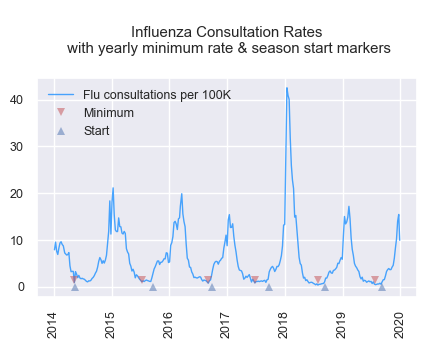

In [47]:
fig = plt.figure(figsize=(4.9, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

handle.plot(flu.index, flu.Flu_rate, color='dodgerblue', alpha = 0.80, linewidth=1, label='Flu consultations per 100K');
handle.plot(minima.Minimum_value_date, minima.y , marker='v', mfc='r', mew=0, markersize=6, alpha=0.5, linewidth=0, label='Minimum');
handle.plot(starts.Season_start, starts.y, marker='^', mfc='b', mew=0, markersize=6, alpha=0.5,  linewidth=0, label='Start');

plt.xticks(rotation=90)
plt.title("\nInfluenza Consultation Rates\n with yearly minimum rate & season start markers\n", fontdict={'fontsize': 'medium'})

handle.legend(loc='upper left', fontsize='small');

<br>
<br>

### Smoothing

<br>

The rolling means; assigned to `flu.Flu_rate_rm_4`

In [48]:
flu.loc[:, 'Flu_rate_rm_4'] = flu.Flu_rate.rolling(window=4).mean()
logger.info(flu.head())


                 Total  Flu_OBS  Flu_rate  year  Flu_rate_rm_4
date                                                          
2014-01-05  28607373.0   2264.0  7.914044  2014            NaN
2014-01-12  29197811.0   2789.0  9.552086  2014            NaN
2014-01-19  29350395.0   2236.0  7.618296  2014            NaN
2014-01-26  28766178.0   1990.0  6.917846  2014       8.000568
2014-02-02  29268260.0   2419.0  8.264926  2014       8.088289
2021-12-20 15:24:29.455



<br>

The graph

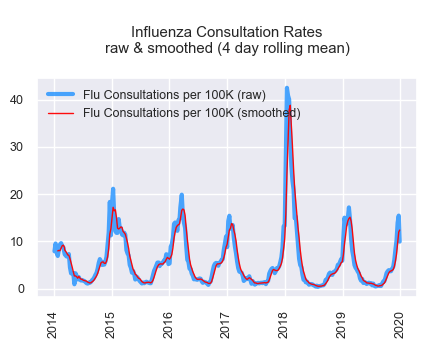

In [49]:
fig = plt.figure(figsize=(4.9, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

handle.plot(flu.index, flu.Flu_rate, color='dodgerblue', alpha = 0.80, linewidth=3, label='Flu Consultations per 100K (raw)');
handle.plot(flu.index, flu.Flu_rate_rm_4, color='red', alpha=0.95, linewidth=1, label='Flu Consultations per 100K (smoothed)');

plt.xticks(rotation=90)
plt.title("\nInfluenza Consultation Rates\nraw & smoothed (4 day rolling mean)\n", fontdict={'fontsize': 'medium'})

handle.legend(loc='upper left', fontsize='small');

<br>
<br>

### Season Start for Smoothed Data

<br>

Excluding the `NaN` values of field `Flu_rate_rm_4`

In [50]:
dataseries = flu.loc[flu.Flu_rate_rm_4.notna(), :]
logger.info(dataseries.head())


                 Total  Flu_OBS  Flu_rate  year  Flu_rate_rm_4
date                                                          
2014-01-26  28766178.0   1990.0  6.917846  2014       8.000568
2014-02-02  29268260.0   2419.0  8.264926  2014       8.088289
2014-02-09  28528280.0   2671.0  9.362639  2014       8.040927
2014-02-16  28803236.0   2775.0  9.634334  2014       8.544936
2014-02-23  29832575.0   2698.0  9.043805  2014       9.076426
2021-12-20 15:24:29.800



<br>

The `Flu_rate_rm_4` minimum value date per year

In [51]:
minima_ = dataseries.groupby(by='year').agg(Minimum_value_date=('Flu_rate_rm_4', when_min))
minima_.loc[:, 'y'] = np.ones(minima_.shape)
minima_

,Minimum_value_date,y
year,,
2014,2014-08-17,1.0
2015,2015-08-02,1.0
2016,2016-09-11,1.0
2017,2017-07-16,1.0
2018,2018-08-05,1.0
2019,2019-08-12,1.0


<br>

The `Flu_rate_rm_4` season start date per year

In [52]:
starts_ = dataseries.groupby(by='year').agg(Season_start=('Flu_rate_rm_4', season_start))
starts_.loc[:, 'y'] = np.zeros(starts_.shape)
starts_

,Season_start,y
year,,
2014,2014-09-28,0.0
2015,2015-10-04,0.0
2016,2016-10-02,0.0
2017,2017-10-01,0.0
2018,2018-09-16,0.0
2019,2019-09-22,0.0


<br>

The graph

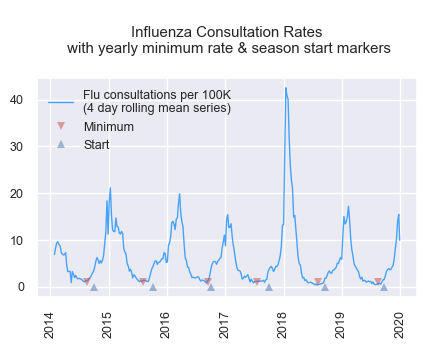

In [53]:
fig = plt.figure(figsize=(4.9, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

handle.plot(dataseries.index, dataseries.Flu_rate, color='dodgerblue', alpha = 0.80, linewidth=1, label='Flu consultations per 100K\n(4 day rolling mean series)');
handle.plot(minima_.Minimum_value_date, minima_.y , marker='v', mfc='r', mew=0, markersize=6, alpha=0.5, linewidth=0, label='Minimum');
handle.plot(starts_.Season_start, starts_.y, marker='^', mfc='b', mew=0, markersize=6, alpha=0.5,  linewidth=0, label='Start');

plt.xticks(rotation=90)
plt.title("\nInfluenza Consultation Rates\n with yearly minimum rate & season start markers\n", fontdict={'fontsize': 'medium'})

handle.legend(loc='upper left', fontsize='small');